# Project - Subspecies of Orchids (20%)
By: Group 10
## Group Members
- Erika Ezliyana binti Mohd Fazli (Data Engineer)
- Emeirul Ezzuddean bin Jefri (Data Scientist)
- Ilhan Nurizzwan bin Azmi (Data Analyst)

# Gathering the Dataset
For this, we have grabbed multiple different sources for the images, mainly from Kaggle.  
Here, we see that there are 35 different sub-species which total up to 49979 images.  
From these sub-species, we picked 5 subspecies that would fit the 10000 images requirements. These include:
- Brassavola (2633)
- Phalaenopsis (2320)
- Paphiopedilum Bellatulum (1795)
- Masdevallia (1725)
- Paphiopedilum Charlesworthii (1665)

These subspecies make up the 10138 images needed for the training of the model.

Source:
- https://www.kaggle.com/datasets/mikful/orchids
- https://www.kaggle.com/datasets/mexwell/orchid-flower-dataset

In [12]:
import os

allFolders = os.listdir("base-dataset")
allFolders.sort()

data = {}

for folder in allFolders:
    data[folder] = len(os.listdir(f"base-dataset/{folder}"))
    newData = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}

print("All Species (in Descending Order)")
pos = 1

total = 0
for key in list(newData.keys()):
    print(f"{pos}. {key} - {newData[key]}")
    pos += 1
    total += newData[key]
print(f"Total Amount in Base Dataset: {total}")
print(f"Total: {len(allFolders)} species")

print("\nTop Species")

pos = 1
total = 0
for key in list(newData.keys())[0:5]:
    print(f"{pos}. {key} - {newData[key]}")
    pos += 1
    total += newData[key]
print(f"Top 5 Total: {total}")

All Species (in Descending Order)
1. Brassavola - 2633
2. Phalaenopsis - 2320
3. Paphiopedilum Bellatulum - 1795
4. Masdevallia - 1725
5. Paphiopedilum Charlesworthii - 1665
6. Bulbophyllum - 1640
7. Encyclia - 1620
8. Paphiopedilum - 1600
9. Epidendrum - 1580
10. Miltoniopsis - 1555
11. Brassia - 1545
12. Cattleya - 1530
13. Lycaste - 1530
14. Angraecum - 1500
15. Bauhinia - 1495
16. Dendrobium Secumdum - 1495
17. Paphiopedilum Callosum - 1450
18. Zygopetalum - 1435
19. Cymbidium - 1430
20. Vanda - 1384
21. Dendrobium - 1339
22. Calypso - 1250
23. Dendrobium Senile - 1245
24. Ophyrs - 1244
25. Phaius - 1240
26. Oncidium - 1180
27. Acampe - 1150
28. Miltonia - 1145
29. Maxillaria - 1100
30. Odontoglossum - 1095
31. Vanilla - 1070
32. Bletilla Striata - 1000
33. Monkey Orchid - 1000
34. Trichoglottis - 1000
35. Stylidium Hispidum - 994
Total Amount in Base Dataset: 49979
Total: 35 species

Top Species
1. Brassavola - 2633
2. Phalaenopsis - 2320
3. Paphiopedilum Bellatulum - 1795
4. Masd

# Preparing the Dataset for Training
In this section, we will prepare the dataset given by the data engineer in which applied image augmented techniques such as flipping and rotation with random cropping approach are applied.  
The dataset is split with a 4:1 ratio, 4 parts for training data, and 1 part for validation data.

In [2]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

dataset = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = dataset.flow_from_directory(
    "dataset",
    target_size=(256, 256),
    class_mode="categorical",
    subset="training"
)

validation_data = dataset.flow_from_directory(
    "dataset",
    target_size=(256, 256),
    class_mode="categorical",
    subset="validation"
)

Found 8111 images belonging to 5 classes.
Found 2027 images belonging to 5 classes.


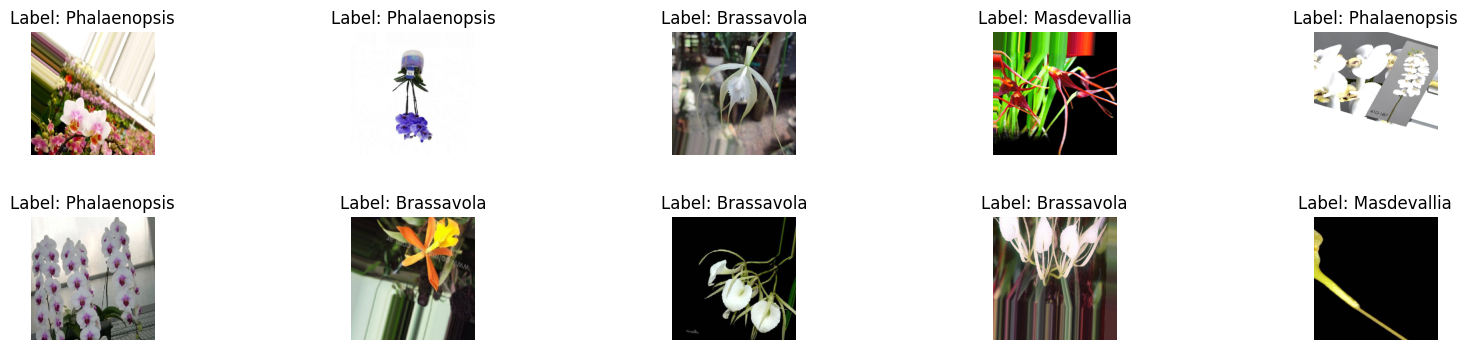

In [10]:
import matplotlib.pyplot as plt
import numpy as np


# Display some images
images, labels = next(train_data)
fig, axes = plt.subplots(2, 5,  figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)

class_indices = train_data.class_indices
class_labels = list(class_indices.keys())
label_indices = np.argmax(labels, axis=1)  

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {class_labels[label_indices[i]]}")  
    ax.axis('off')

plt.show()


Below is a bar chart diagram which preview the distribution of available image gathered across 5 subspecies in the dataset

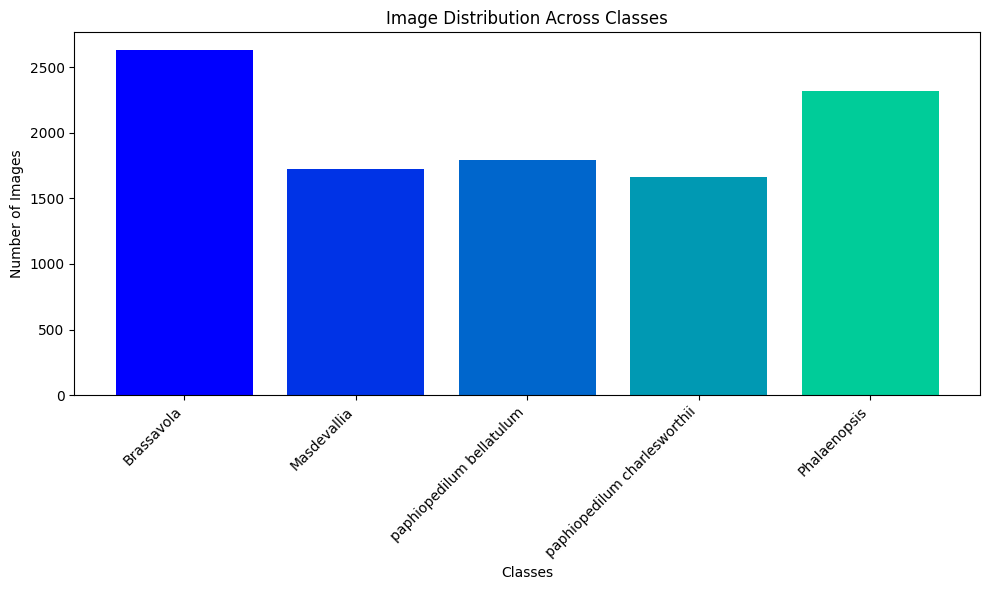

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np

class DatasetAnalyzer:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.class_counts = {}

    def count_images_per_class(self):
        """Count the number of images in each class directory."""
        for class_dir in os.listdir(self.data_dir):
            class_path = os.path.join(self.data_dir, class_dir)
            if os.path.isdir(class_path):
                self.class_counts[class_dir] = len(os.listdir(class_path))
        return self.class_counts

    def plot_class_distribution(self):
        """Plot the distribution of images across classes with a color gradient."""
        classes = list(self.class_counts.keys())
        counts = list(self.class_counts.values())

        # Create a color gradient based on the number of classes
        colormap = plt.get_cmap("winter") 
        colors = [colormap(i / len(classes)) for i in range(len(classes))]

        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts, color=colors)
        plt.xlabel("Classes")
        plt.ylabel("Number of Images")
        plt.title("Image Distribution Across Classes")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
        plt.show()

if __name__ == "__main__":
    data_directory = "dataset"  # Replace with the actual path
    analyzer = DatasetAnalyzer(data_directory)
    class_counts = analyzer.count_images_per_class()
    analyzer.plot_class_distribution()


# 2. Compiling/Training the Model
The model will now be compiled, this model has additional layers such as `RandomRotation` and `RandomZoom` as additional data augmentation to ensure that the model is trained to predict images even when they are slightly rotated or zoomed in.

In [2]:
from tensorflow import keras
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, RandomRotation, RandomZoom, BatchNormalization

model = keras.Sequential([
    Input((256, 256, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(64, (3, 3), activation='leaky_relu'),
    MaxPooling2D((3, 3)),
    Conv2D(32, (3, 3), activation='leaky_relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='leaky_relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, kernel_regularizer="l2", activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In the code block below, we also use `ReduceLROnPlateau`. This model fitting callback instructs the training system to reduce the learning rate of the model so that the validation accuracy is similar to the training accuracy.

In [17]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data,
    validation_steps=50,  # Number of validation batches,
    callbacks=[reduce_lr]
)

Epoch 1/10


2025-01-16 03:37:33.463859: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 03:37:33.593965: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

171/254 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - accuracy: 0.5058 - loss: 2.3082

2025-01-16 03:39:14.175668: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 03:39:14.359891: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

254/254 ━━━━━━━━━━━━━━━━━━━━ 194s 641ms/step - accuracy: 0.5430 - loss: 1.9444 - val_accuracy: 0.8100 - val_loss: 0.5425 - learning_rate: 0.0010
Epoch 2/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 134s 527ms/step - accuracy: 0.7710 - loss: 0.6011 - val_accuracy: 0.8631 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 3/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 132s 517ms/step - accuracy: 0.8142 - loss: 0.4893 - val_accuracy: 0.8569 - val_loss: 0.3890 - learning_rate: 0.0010
Epoch 4/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 141s 553ms/step - accuracy: 0.8128 - loss: 0.4560 - val_accuracy: 0.8763 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 5/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 151s 590ms/step - accuracy: 0.8474 - loss: 0.3791 - val_accuracy: 0.8900 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 6/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 201s 792ms/step - accuracy: 0.8694 - loss: 0.3202 - val_accuracy: 0.8850 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 7/10
254/254 ━━━━━━━━━━━━━━━━━━━━ 148s 576ms/step - accuracy: 0.8695 

Display and review the model summary


In [ ]:
model.summary()

We will now save the model with the filename `categorical1.keras`.

In [18]:
model.save("categorical1.keras")

# 3. Validating Model for Overfitting/Underfitting
In the code below, we will check for the training and validation accuracy.  
Throughout the training session, we noticed that the validation accuracy was able to keep up with the training accuracy. This is further confirmed by the graph shown below as the final validation accuracy was not too far off from the training accuracy towards the end of the training session.

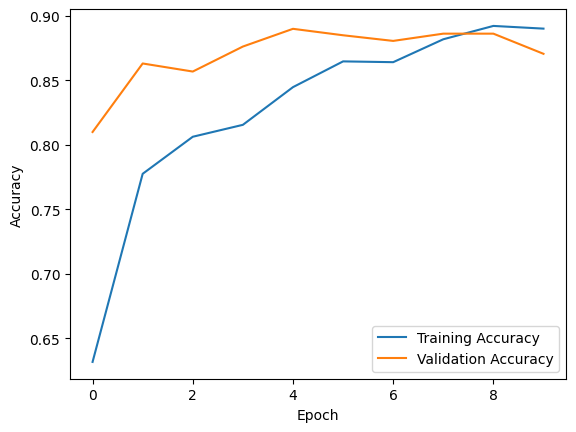

In [19]:
import matplotlib.pyplot as plt

# Get the plot of the training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Get the plot of the training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend

# 4. Validating the Model Against Real Data
This section covers validating the model for it's accuracy when data is cherry picked for verification of the model's predictions.  
As shown below, the model was able to attain 100% accuracy with the model being able to get 70-100% accuracy on multiple runs of testing.

{'Brassavola': 0, 'Masdevallia': 1, 'Paphiopedilum Bellatulum': 2, 'Paphiopedilum Charlesworthii': 3, 'Phalaenopsis': 4}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


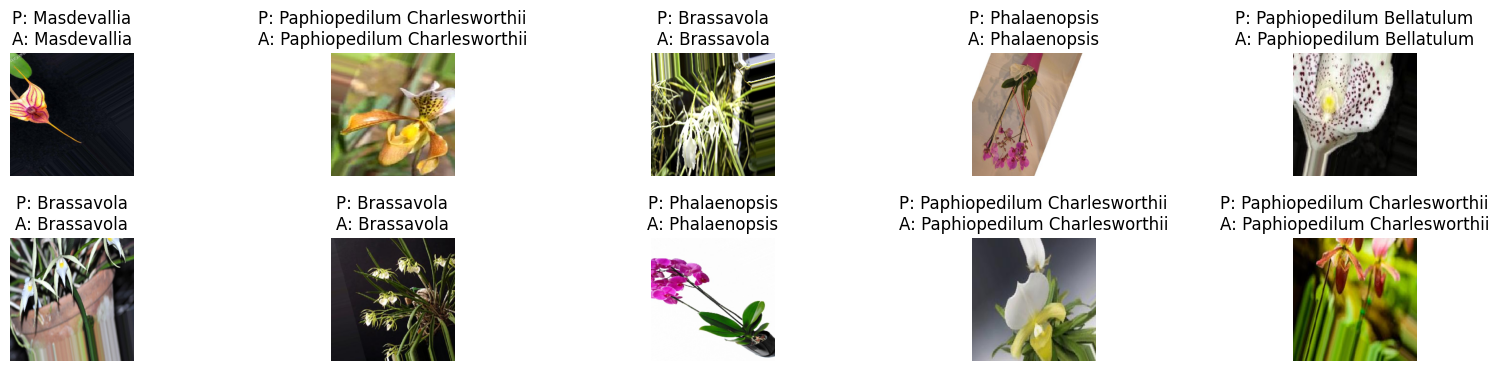

100.0%


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model("categorical1.keras")

# Choose a few random samples from the validation set
num_samples_to_display = 10
sample_indices = np.random.choice(len(validation_data), num_samples_to_display, replace=False)
count = 0
print(validation_data.class_indices)

# Create a function for showing the subspecies of the orchid
def getClassLabel(index: int):
    indices = validation_data.class_indices
    for key in list(indices.keys()):
        if indices[key] == index:
            return key

# Display the samples and their predicted and actual labels
fig, axes = plt.subplots(2, int(num_samples_to_display / 2), figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    sample_index = sample_indices[i]
    image, label = validation_data[sample_index]
    
    # Extract individual image from batch
    image = image[0]
    
    # Make prediction using the model
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction[0])
    
    ax.imshow(image)
    ax.set_title(f"P: {getClassLabel(predicted_label)}\nA: {getClassLabel(np.argmax(label[0]))}")
    ax.axis('off')
    if predicted_label == np.argmax(label[0]):
        count += 1

plt.show()
print(f"{(count/10) * 100}%")

For the code below, we have taken some few images from the internet as to ensure some randomness is taken into account during the validation tests.  
As is what's shown below, the above situation also applies here as the model was able to achieve 70-100% accuracy, with the one below showing a 90% accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


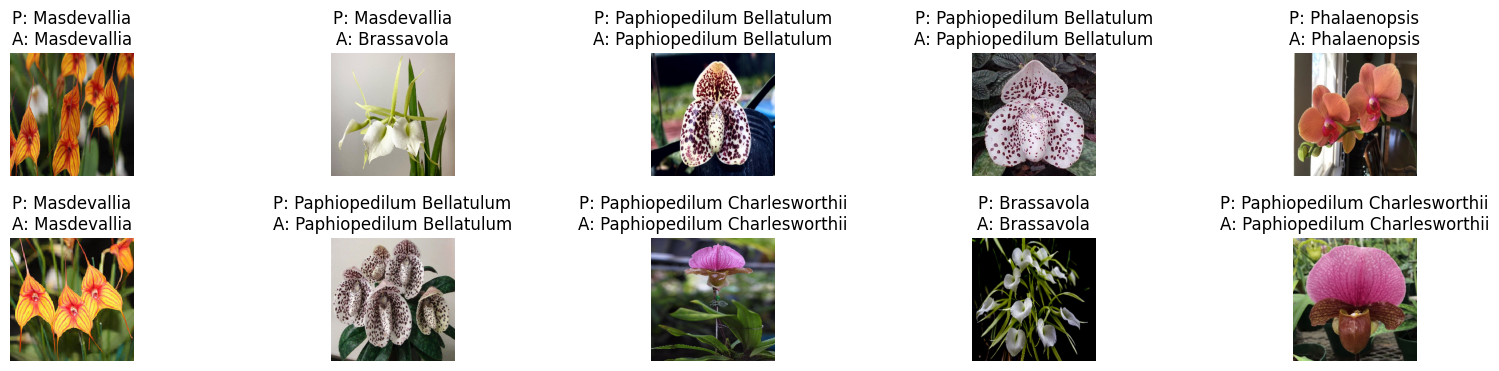

90.0%


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# Define the variables needed for this code block
indices = {'Brassavola': 0, 'Masdevallia': 1, 'Paphiopedilum Bellatulum': 2, 'Paphiopedilum Charlesworthii': 3, 'Phalaenopsis': 4}
folder_path = "testing-data"

# Get the list of image file names
image_files = os.listdir(folder_path)

# Choose a few random samples from the folder
num_samples_to_display = 10
sample_indices = np.random.choice(len(image_files), num_samples_to_display, replace=False)
count = 0

# Create a function for showing the subspecies of the orchid
def getClassLabel(index: int):
    for key in list(indices.keys()):
        if indices[key] == index:
            return key

# Display the samples and their predicted and actual labels
fig, axes = plt.subplots(2, int(num_samples_to_display / 2), figsize=(20, 4))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flat):
    sample_index = sample_indices[i]
    file_name = image_files[sample_index]
    img_path = os.path.join(folder_path, file_name)
    species_name = file_name.split(".")[0]
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction using the model
    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction[0])
    
    ax.imshow(img)
    ax.set_title(f"P: {getClassLabel(predicted_label)}\nA: {species_name}")
    ax.axis('off')
    if getClassLabel(predicted_label) == species_name:
        count += 1

plt.show()
print(f"{(count/10) * 100}%")

# 5. Confusion Matrix graph analysis
This section covers the confusion matrix graph in which present different classification rate of confusion across 5 orchid subspecies

The off-diagonal matrix values reveal that the model have misclassification across orchid subspecies. This indicate that the model often confuse with various orchid subspecies. 

It shows that the model perform well on `Phalaenopsis` in which have the most correct prediction. The model oftenly confused with `Brassavola`orchid.

/home/pleb/artificial-intelligence/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-16 17:01:58.800642: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_o

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step

2025-01-16 17:02:36.451664: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[11,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 17:02:36.503825: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[11,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 494ms/step


<Figure size 1000x800 with 0 Axes>

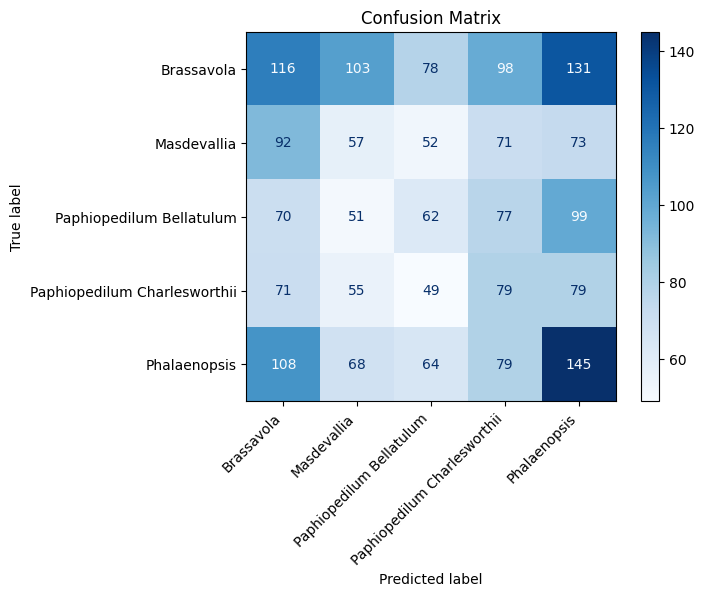

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = validation_data.classes  
y_pred = model.predict(validation_data)
y_pred_classes = np.argmax(y_pred, axis=1)  

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_data.class_indices.keys())
plt.figure(figsize=(10, 8))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')  
plt.title('Confusion Matrix')
plt.show()


# 6. Final Takeaways

The `model parameter` consists of 23,104,837 parameters which present adequately complex model architecture. 

`validation accuracy` and `testing accuracy` shows a relatively high values. We can suggests that the model generalize well to unseen orchid images across 5 subspecies. Although the model can generalizes to different orchid images, the model still not highly accurate enough to pinpoint the orchid subspecies on several testing occassions effectively. 

`Precision`, `Recall` and `mAP` metric values is significantly low values. This can indicate that the model won't be able to identifying orchid across different subspecies effectively and accurately.

---

### Area of Improvement 
- Achive higher accuracy percentage with ideal metric value across different criteria
- Include higher orchid images count for the subspecies in the  dataset
- Improve image augmentation techniques to include more unseen image of orchid dataset to be trained on
- Trying to add on different model architecture or hyperparameter

In [6]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, average_precision_score

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_data)

y_true = validation_data.classes 
y_pred_probs = model.predict(validation_data)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Final Conclusion:")
print(f"Model's Parameters: {model.count_params()}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss}")

# Prepare test data for evaluation
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    'dataset',  
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'  
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f'Test Loss: {test_loss}')

# Calculate precision and recall
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Binarize the true labels
n_classes = len(validation_data.class_indices)  # Number of classes
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# Calculate Average Precision for each class
average_precisions = []
for i in range(n_classes):
    ap = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])
    average_precisions.append(ap)

# Calculate mean Average Precision (mAP)
mAP = np.mean(average_precisions)
print(f"Mean Average Precision (mAP): {mAP:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - accuracy: 0.8775 - loss: 0.4001
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 371ms/step
Final Conclusion:
Model's Parameters: 23104837
Validation Accuracy: 87.22%
Validation Loss: 0.4234216809272766
Found 10138 images belonging to 5 classes.


/home/pleb/artificial-intelligence/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-16 17:03:51.118258: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_o

506/507 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9499 - loss: 0.1590

2025-01-16 17:06:05.128676: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[18,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-16 17:06:05.498943: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[18,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

507/507 ━━━━━━━━━━━━━━━━━━━━ 146s 265ms/step - accuracy: 0.9499 - loss: 0.1590
Test Accuracy: 94.91%
Test Loss: 0.1632111817598343
Precision: 0.1872
Recall: 0.1880
Mean Average Precision (mAP): 0.1910
